In [1]:
import glob
import h5py
import numpy as np
import os
import pylab
import scipy.linalg
import scipy as sp
import sys
from os.path import dirname
sys.path.append(dirname("C:\Users\hp\Documents\GitHub\Circuit_Notebooks\lib\ProjectQ-develop\projectq"))
import logging

from numpy import array, concatenate, zeros
from numpy.random import randn
from scipy.optimize import minimize

from functools import reduce


print(sys.executable)

from openfermion.config import *
from openfermionprojectq import *

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, get_sparse_operator
from openfermion.utils import uccsd_singlet_paramsize
from openfermion.ops import FermionOperator

from openfermionpsi4 import run_psi4

from projectq.ops import X, All, Measure
from projectq.backends import CommandPrinter, CircuitDrawer
from projectq.ops import (BasicGate,
                          H,
                          X,
                          CNOT,
                          Measure,
                          Z,
                          Swap,
                          C,
                          Rx,
                          Rz)
from projectq.backends._circuits import to_latex
from projectq.backends import _printer

import random, math

%matplotlib inline

hartree_to_kcal = 627.50947415

C:\Users\hp\Documents\Github\CircuitNotebooks\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


C:\Users\hp\Documents\Github\CircuitNotebooks\Scripts\python.exe
(Note: This is the (slow) Python simulator.)


In [2]:
def canonical_eigh(M, S):
    """Return the eigenvectors and eigenvalues in the original basis with potentially singular S"""
    #Solve for spectrum with canonical orthogonalization
    overlapCutoff = 1.0e-8
    [evals, evecs] = sp.linalg.eigh(S)

    #Determine rank
    RankOverlap = np.sum(evals > overlapCutoff)
    nullity = len(evals) - RankOverlap
    #Cutoff
    evals = evals[nullity:]
    evecs = evecs[:, nullity:]

    #Make transformation matrix
    U = np.dot(evecs, np.diag(evals**(-0.5)))

    #Transform the Hamiltonian and find the new eigenvectors
    M_prime = np.dot(np.conj(U).T, np.dot(M, U))
    S_prime = np.dot(np.conj(U).T, np.dot(S, U))

    e_vals, e_vecs = sp.linalg.eigh(M_prime, S_prime)
    #Transform eigenvectors back to original basis
    e_vecs = np.dot(U, e_vecs)
    
    return e_vals, e_vecs, U

def FindSymmTransform(M, S, val):
    """Find a transform to project onto the eigenspace corresponding to eigenvalue val of operator 
    representation M with overlap S"""
    e_vals, e_vecs, U = canonical_eigh(M, S)
    indices = np.where(np.abs(e_vals-val) < 0.1)[0]
    U = e_vecs[:, indices]
    return U

In [3]:
# Load files
# molecule_filenames = sorted(glob.glob('data/*.hdf5'))

# Load only 0 and pi/2
molecule_filenames = ['data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5','data/H4-C2_DZP_singlet_ethylene_1.57080.hdf5']

test_molecule = MolecularData(filename=molecule_filenames[0])
print("Number of spatial basis functions: {}".format(test_molecule.n_orbitals))
print("Number of electrons: {}".format(test_molecule.n_electrons))
test_molecule = None

Number of spatial basis functions: 52
Number of electrons: 16


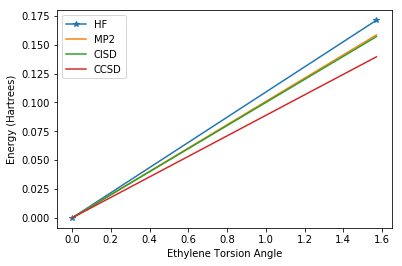

In [4]:
# Plot CCSD curve for angle
angles = []
hf_energies = []
mp2_energies = []
cisd_energies = []
ccsd_energies = []

for filename in molecule_filenames:
    angle = float(filename.split('_')[-1].rstrip('.hdf5'))
    molecule = MolecularData(filename=filename)
    
    angles.append(angle)
    hf_energies.append(molecule.hf_energy)
    mp2_energies.append(molecule.mp2_energy)
    cisd_energies.append(molecule.cisd_energy)
    ccsd_energies.append(molecule.ccsd_energy)

pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Energy (Hartrees)")
pylab.plot(angles, np.array(hf_energies) - hf_energies[0], '*-', label="HF")
pylab.plot(angles, np.array(mp2_energies) - mp2_energies[0], label="MP2")
pylab.plot(angles, np.array(cisd_energies) - cisd_energies[0], label="CISD")
pylab.plot(angles, np.array(ccsd_energies) - ccsd_energies[0], label="CCSD")
pylab.legend()

Qubit Hamiltonian Matrix
[[-76.86638025+0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j]
 [  0.        +0.j -77.51323099+0.j   0.        +0.j   0.0904036 +0.j
    0.        +0.j]
 [  0.        +0.j   0.        +0.j -77.71195749+0.j   0.        +0.j
    0.        +0.j]
 [  0.        +0.j   0.0904036 +0.j   0.        +0.j -78.04891685+0.j
    0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j
  -77.42507323+0.j]]
()
Energy: -78.0637621652	 Number: (2+0j)	 Sz:0j	 S^2:0j
Qubit Hamiltonian Matrix
[[-7.69835371e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -7.78581004e+01+0.j -3.37958704e-07+0.j
   6.60851702e-02+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -3.37958704e-07+0.j -7.78078748e+01+0.j
   8.86707696e-08+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  6.60851702e-02+0.j  8.86707693e-08+0.j
  -7.78778203e+01+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j 

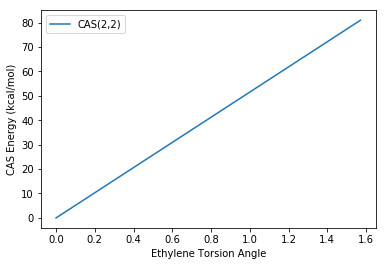

In [5]:
# Examine a CAS(n electrons, n spatial orbitals) active space - 2 x number spatial orbitals = qubits
angles = [float(filename.split('_')[-1].rstrip('.hdf5')) for filename in molecule_filenames]
cas_energies = {}
original_electrons = 16

# for n_electrons, n_orbitals in [(2,1), (2,2), (4,4)]:
for n_electrons, n_orbitals in [(2,2)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = get_sparse_operator(jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))).todense()
    spinx_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spiny_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), -0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spinz_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spin2_operator = (np.dot(spinx_operator, spinx_operator) +
                      np.dot(spiny_operator, spiny_operator) +
                      np.dot(spinz_operator, spinz_operator))
    cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    for filename in molecule_filenames:
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # Build qubit Hamiltonian
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

        # Build matrix representation & diagonalize
        qubit_hamiltonian_matrix = get_sparse_operator(hamiltonian).todense()

        # Project to S^2 = 0 subspace
        U_s2 = FindSymmTransform(spin2_operator, 
                                 np.eye(spin2_operator.shape[0]),
                                 0.0)
        qubit_hamiltonian_matrix = np.dot(np.conj(U_s2).T, np.dot(qubit_hamiltonian_matrix, U_s2))
        
        print('Qubit Hamiltonian Matrix')
        print(qubit_hamiltonian_matrix)
        print()
        
        eigvals, eigvecs = scipy.linalg.eigh(qubit_hamiltonian_matrix)
        ground_state = eigvecs[:,0][:, np.newaxis]
        energy = eigvals[0]
        number = reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, number_operator, U_s2, ground_state))[0,0]
        spinz =  reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, spinz_operator, U_s2, ground_state))[0,0]
        spin2 =  reduce(np.dot,
                       (np.conj(ground_state.T), np.conj(U_s2).T, spin2_operator, U_s2, ground_state))[0,0]
        
        cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(energy)
        print('Energy: {}\t Number: {}\t Sz:{}\t S^2:{}'.format(energy, number, spinz, spin2))
        
    
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("CAS Energy (kcal/mol)")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

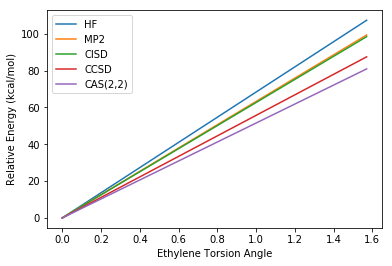

In [6]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

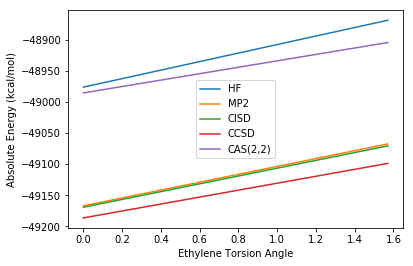

In [7]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Absolute Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * np.array(hf_energies), label="HF")
pylab.plot(angles, hartree_to_kcal * np.array(mp2_energies), label="MP2")
pylab.plot(angles, hartree_to_kcal * np.array(cisd_energies), label="CISD")
pylab.plot(angles, hartree_to_kcal * np.array(ccsd_energies), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * np.array(cas_energies[key]),
               label=key)
pylab.legend()

In [8]:
# Make a UCC Singlet Ansatz for CAS(2,2) at a particular geometry
results = {}
results['0.00000rad Iterations'] = []
results['0.00000rad Initial Energies'] = []
results['0.00000rad Initial Amplitudes'] = []
results['0.00000rad Optimal Energies'] = []
results['0.00000rad Optimal Amplitudes'] = []
results['1.57080rad Iterations'] = []
results['1.57080rad Initial Energies'] = []
results['1.57080rad Initial Amplitudes'] = []
results['1.57080rad Optimal Energies'] = []
results['1.57080rad Optimal Amplitudes'] = []

uccsd_energies = {}
uccsd_amplitudes = {}
original_electrons = 16

N = 30

for iteration in range(0, N):
    for n_electrons, n_orbitals in [(2,2)]:

        occupied_indices = range(8 - n_electrons // 2)
        active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
        active_electrons = original_electrons - len(occupied_indices) * 2
        active_qubits = len(active_indices) * 2

        # Define a qubit number operator
        number_operator = jordan_wigner(
            sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
        number_operator.compress()
        spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                            for i in range(active_qubits // 2)], FermionOperator()) +
                                       sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                            for i in range(active_qubits // 2)], FermionOperator()))
        spinz_operator.compress()

        n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, 
                                               active_electrons))
#         print("Running CAS({},{}) with {} coupled cluster amplitudes".format(n_electrons, n_orbitals,n_amplitudes))
        current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
        uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
        uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)] = []

        for file_index, filename in enumerate(molecule_filenames):
            angle = filename.split('_')[-1].rstrip('.hdf5')
            iters = 0

#             print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
            molecule = MolecularData(filename=filename)
            # Extract active space integrals
            hamiltonian = (molecule.
                           get_molecular_hamiltonian(
                               occupied_indices=occupied_indices,
                               active_indices=active_indices))
            fermion_hamiltonian = get_fermion_operator(hamiltonian)


            # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components
            qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
            qubit_hamiltonian.compress()

            # Set standard UCCSD Compiler engine
            compiler_engine = uccsd_trotter_engine()

            def energy_objective(packed_amplitudes):
                """Evaluate the energy of a UCCSD singlet wavefunction with packed_amplitudes
                Args:
                    packed_amplitudes(ndarray): Compact array that stores the unique
                        amplitudes for a UCCSD singlet wavefunction.

                Returns:
                    energy(float): Energy corresponding to the given amplitudes
                """
                # Set Jordan-Wigner initial state with correct number of electrons
                wavefunction = compiler_engine.allocate_qureg(active_qubits)

                # Set some of the qubits to |1>, or occupied
                for i in range(active_electrons):
                    X | wavefunction[i]

                # Build the circuit and act it on the wavefunction
                evolution_operator = uccsd_singlet_evolution(packed_amplitudes, 
                                                             active_qubits, 
                                                             active_electrons)
                evolution_operator | wavefunction
                compiler_engine.flush()

                # Evaluate the energy and reset wavefunction
                energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
                number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
                spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
#                 print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
                All(Measure) | wavefunction
                compiler_engine.flush()

                global iters
                iters += 1

                return energy

            initial_energy = energy_objective(current_amplitudes)

            # Run VQE Optimization to find new CCSD parameters
            opt_result = minimize(energy_objective, current_amplitudes,
                                  method="l-bfgs-b", options={'disp':True})

            opt_energy, opt_amplitudes = opt_result.fun, opt_result.x
            
            
            results['{}rad Initial Amplitudes'.format(angle)].append(current_amplitudes)

            # Use previous iteration as guess for next iteration
            current_amplitudes = opt_amplitudes[:]

            # Store energy and amplitudes
            uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(opt_energy)
            uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)].append([opt_amplitudes])

            #Store for file dumping
            results['{}rad Iterations'.format(angle)].append(iters)
            results['{}rad Initial Energies'.format(angle)].append(initial_energy)
            results['{}rad Optimal Energies'.format(angle)].append(opt_energy)
            results['{}rad Optimal Amplitudes'.format(angle)].append(opt_amplitudes)

#             print("\nInitial Energy: {}".format(initial_energy))
#             print("Optimal UCCSD Singlet Energy: {}".format(opt_energy))
#             print("Optimal UCCSD Singlet Amplitudes: {}".format(opt_amplitudes))
#             print("Exact FCI Energy: {} Hartrees".format(
#                     cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))

print(uccsd_energies)
print(uccsd_amplitudes)

# Set up file for storing repeated results
import pickle
name = "data/ethylene_2_2_ethylene4_results_py"

f = open(name, "wb")
pickle.dump(results, f, -1)
f.close()

f2 = open(name, "rb")
b = pickle.load(f2)
print(b)
f2.close()


{'CAS(2,2)': [-78.06376216473906, -77.93477677930156]}
{'CAS(2,2)': [[array([-1.47303515e-05,  8.13904557e-02])], [array([0.00060436, 0.35615508])]]}
{'0.00000rad Iterations': [22, 22, 40, 28, 22, 28, 34, 28, 22, 34, 31, 25, 25, 31, 28, 34, 16, 22, 28, 25, 16, 25, 25, 25, 28, 25, 40, 28, 28, 31], '0.00000rad Initial Energies': [-78.04871230577584, -78.04858772083132, -78.04962962131837, -78.04858324073743, -78.04877301970465, -78.04901279980042, -78.04937884158662, -78.04856076826644, -78.04884907451132, -78.04920230703564, -78.0487396217048, -78.0495757587787, -78.0491257398122, -78.04901794802745, -78.04927627813177, -78.04929724971669, -78.04887477820297, -78.04890808489506, -78.04927944889197, -78.0494364359735, -78.04892766861664, -78.04920224020854, -78.04878721199813, -78.04893119879533, -78.04923322471957, -78.04936056852902, -78.04832501552279, -78.04854658511437, -78.04821459562092, -78.04916166967112], '1.57080rad Optimal Energies': [-77.93477702643378, -77.93477702184053, -

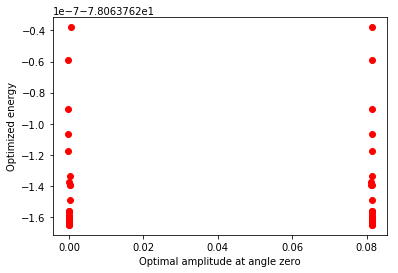

In [9]:
pylab.xlabel("Optimal amplitude at angle zero")
pylab.ylabel("Optimized energy")
zero_opt_amplitudes = b['0.00000rad Optimal Amplitudes']
zero_opt_energies = b['0.00000rad Optimal Energies']
pylab.plot(zero_opt_amplitudes, zero_opt_energies, 'ro')

Text(0.5,1,'Second amplitude element')

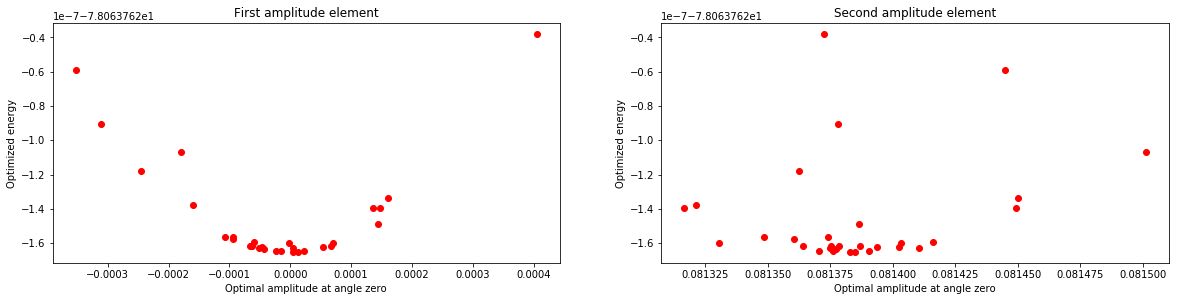

In [10]:
y = b['0.00000rad Optimal Amplitudes']
zero_opt_amplitudes_neg = [x[0] for x in y]
zero_opt_amplitudes_pos = [x[1] for x in y]
zero_opt_energies = b['0.00000rad Optimal Energies']

fig = pylab.figure(figsize=(20,15))
pylab.subplot(3,2,1)
pylab.plot(zero_opt_amplitudes_neg, zero_opt_energies, 'ro')
pylab.xlabel("Optimal amplitude at angle zero")
pylab.ylabel("Optimized energy")
pylab.title("First amplitude element")

pylab.subplot(3,2,2)
pylab.plot(zero_opt_amplitudes_pos, zero_opt_energies, 'ro')
pylab.xlabel("Optimal amplitude at angle zero")
pylab.ylabel("Optimized energy")
pylab.title("Second amplitude element")


Text(0.5,1,'Second amplitude element')

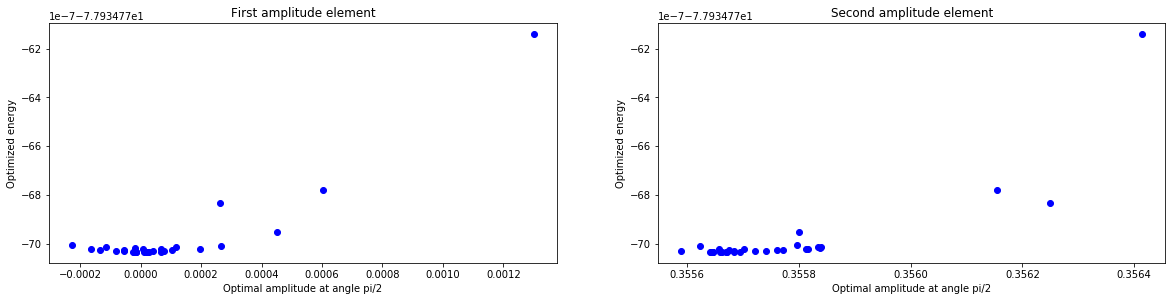

In [11]:
y = b['1.57080rad Optimal Amplitudes']
halfpi_opt_amplitudes_neg = [x[0] for x in y]
halfpi_opt_amplitudes_pos = [x[1] for x in y]
halfpi_opt_energies = b['1.57080rad Optimal Energies']

fig = pylab.figure(figsize=(20,15))
pylab.subplot(3,2,1)
pylab.plot(halfpi_opt_amplitudes_neg, halfpi_opt_energies, 'bo')
pylab.xlabel("Optimal amplitude at angle pi/2")
pylab.ylabel("Optimized energy")
pylab.title("First amplitude element")

pylab.subplot(3,2,2)
pylab.plot(halfpi_opt_amplitudes_pos, halfpi_opt_energies, 'bo')
pylab.xlabel("Optimal amplitude at angle pi/2")
pylab.ylabel("Optimized energy")
pylab.title("Second amplitude element")

Text(0.5,1,'Second amplitude element')

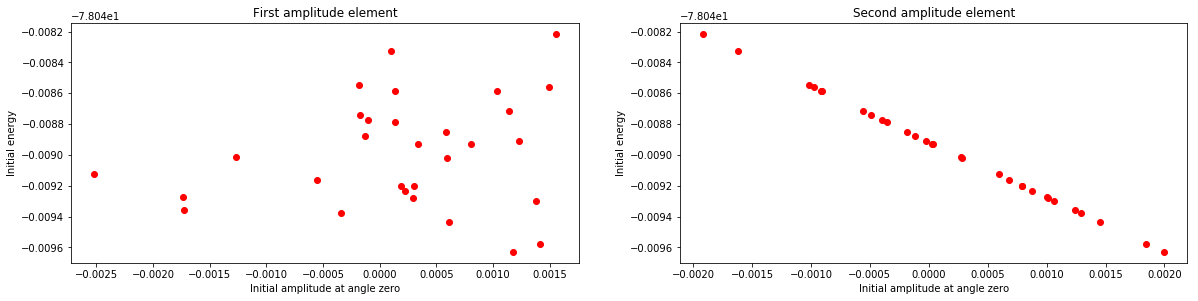

In [12]:
y = b['0.00000rad Initial Amplitudes']
zero_init_amplitudes_neg = [x[0] for x in y]
zero_init_amplitudes_pos = [x[1] for x in y]
zero_init_energies = b['0.00000rad Initial Energies']

fig = pylab.figure(figsize=(20,15))
pylab.subplot(3,2,1)
pylab.plot(zero_init_amplitudes_neg, zero_init_energies, 'ro')
pylab.xlabel("Initial amplitude at angle zero")
pylab.ylabel("Initial energy")
pylab.title("First amplitude element")

pylab.subplot(3,2,2)
pylab.plot(zero_init_amplitudes_pos, zero_init_energies, 'ro')
pylab.xlabel("Initial amplitude at angle zero")
pylab.ylabel("Initial energy")
pylab.title("Second amplitude element")

Text(0.5,1,'Second amplitude element')

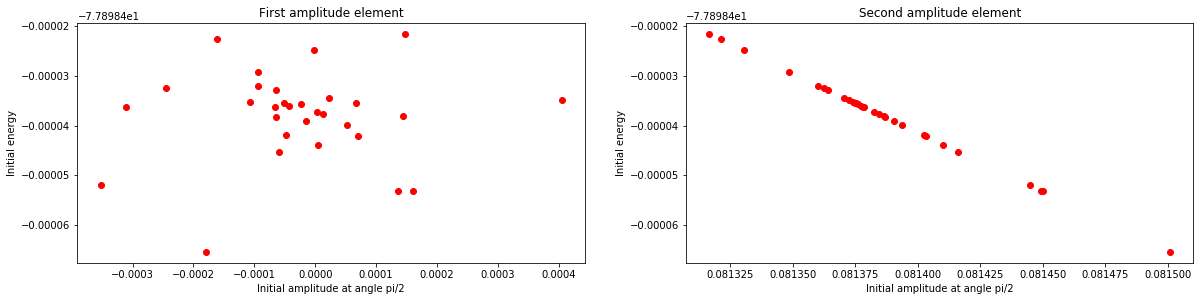

In [13]:
y = b['1.57080rad Initial Amplitudes']
halfpi_init_amplitudes_neg = [x[0] for x in y]
halfpi_init_amplitudes_pos = [x[1] for x in y]
halfpi_init_energies = b['1.57080rad Initial Energies']

fig = pylab.figure(figsize=(20,15))
pylab.subplot(3,2,1)
pylab.plot(halfpi_init_amplitudes_neg, halfpi_init_energies, 'ro')
pylab.xlabel("Initial amplitude at angle pi/2")
pylab.ylabel("Initial energy")
pylab.title("First amplitude element")

pylab.subplot(3,2,2)
pylab.plot(halfpi_init_amplitudes_pos, halfpi_init_energies, 'ro')
pylab.xlabel("Initial amplitude at angle pi/2")
pylab.ylabel("Initial energy")
pylab.title("Second amplitude element")

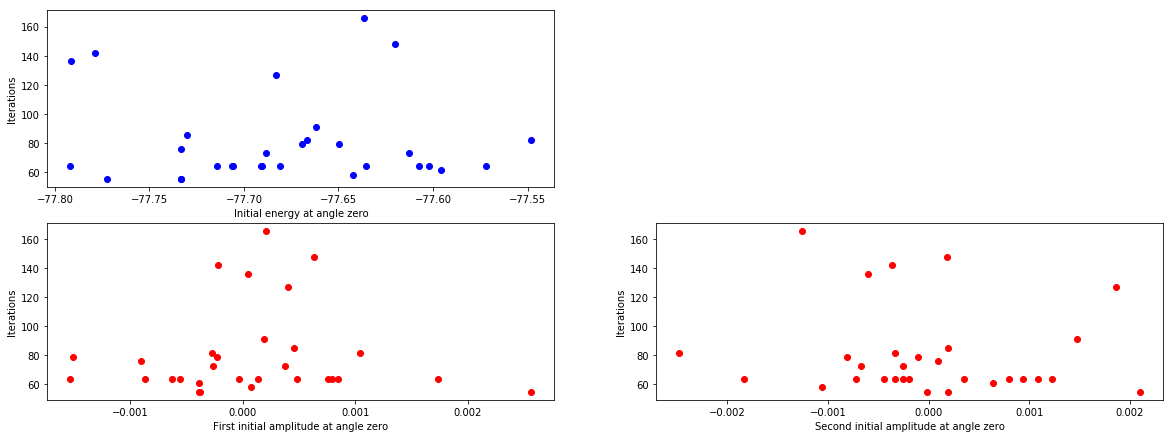

In [14]:
fig = pylab.figure(figsize=(20,15))

# pylab.subplot(4,2,3)
# pylab.xlabel("Initial energy at angle pi/2")
# pylab.ylabel("Iterations")
# halfpi_iterations = b['1.57080rad Iterations']
# halfpi_init_energies = b['1.57080rad Initial Energies']

# pylab.plot(halfpi_init_energies, halfpi_iterations, 'bo')

pylab.subplot(4,2,3)
pylab.xlabel("Initial energy at angle zero")
pylab.ylabel("Iterations")
zero_iterations = b['0.00000rad Iterations']
zero_init_energies = b['0.00000rad Initial Energies']

pylab.plot(zero_init_energies, zero_iterations, 'bo')

# pylab.subplot(4,2,5)
# pylab.xlabel("Initial amplitudes at angle pi/2")
# pylab.ylabel("Iterations")
# halfpi_iterations = b['1.57080rad Iterations']
# halfpi_init_amps = b['1.57080rad Initial Amplitudes']

# pylab.plot(halfpi_init_amps, halfpi_iterations, 'ro')

pylab.subplot(4,2,5)
pylab.xlabel("First initial amplitude at angle zero")
pylab.ylabel("Iterations")
zero_iterations = b['0.00000rad Iterations']
zero_init_amps = [x[0] for x in b['0.00000rad Initial Amplitudes']]

pylab.plot(zero_init_amps, zero_iterations, 'ro')


pylab.subplot(4,2,6)
pylab.xlabel("Second initial amplitude at angle zero")
pylab.ylabel("Iterations")
zero_iterations = b['0.00000rad Iterations']
zero_init_amps = [x[1] for x in b['0.00000rad Initial Amplitudes']]

pylab.plot(zero_init_amps, zero_iterations, 'ro')

In [24]:
# Print out the commands submitted to the engine
cmd_printer = _printer.CommandPrinter()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(cmd_printer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()

Allocate | Qureg[0]
Allocate | Qureg[1]
Allocate | Qureg[2]
Allocate | Qureg[3]
X | Qureg[0]
X | Qureg[1]
Rx(1.5707963268) | Qureg[1]
H | Qureg[3]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.5656665145) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
H | Qureg[3]
Rx(10.9955742876) | Qureg[1]
Rx(1.5707963268) | Qureg[0]
H | Qureg[1]
Rx(1.5707963268) | Qureg[2]
Rx(1.5707963268) | Qureg[3]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.566235567) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
Rx(10.9955742876) | Qureg[3]
Rx(10.9955742876) | Qureg[2]
H | Qureg[1]
Rx(10.9955742876) | Qureg[0]
H | Qureg[0]
H | Qureg[1]
Rx(1.5707963268) | Qureg[2]
H | Qureg[3]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.566235567) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[3]
R

In [25]:
# Generate the circuit diagram and print it
drawer = CircuitDrawer()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(drawer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()
circuit = drawer.get_latex()
print(circuit)

Deallocate | Qureg[3]
Deallocate | Qureg[2]
Deallocate | Qureg[1]
Deallocate | Qureg[0]
\documentclass{standalone}
\usepackage[margin=1in]{geometry}
\usepackage[hang,small,bf]{caption}
\usepackage{tikz}
\usepackage{braket}
\usetikzlibrary{backgrounds,shadows.blur,fit,decorations.pathreplacing,shapes}

\begin{document}
\begin{tikzpicture}[scale=0.8, transform shape]

\tikzstyle{basicshadow}=[blur shadow={shadow blur steps=8, shadow xshift=0.7pt, shadow yshift=-0.7pt, shadow scale=1.02}]\tikzstyle{basic}=[draw,fill=white,basicshadow]
\tikzstyle{operator}=[basic,minimum size=1.5em]
\tikzstyle{phase}=[fill=black,shape=circle,minimum size=0.1cm,inner sep=0pt,outer sep=0pt,draw=black]
\tikzstyle{none}=[inner sep=0pt,outer sep=-.5pt,minimum height=0.5cm+1pt]
\tikzstyle{measure}=[operator,inner sep=0pt,minimum height=0.5cm, minimum width=0.75cm]
\tikzstyle{xstyle}=[circle,basic,minimum height=0.35cm,minimum width=0.35cm,inner sep=-1pt,very thin]
\tikzset{
shadowed/.style={preaction={transform 

In [34]:
# Make a custom ansatz for CAS(2,2) at a particular geometry
# UCCSD has only one single and one double excitation operator; The custom ansatz only tackles the double exitation
from projectq import MainEngine
from projectq.ops import H, X, Rz, Rx, CNOT
from projectq.meta import Control

mini_energies = {}
mini_amplitudes = {}
original_electrons = 16
n_electrons = 2
n_orbitals = 2
for target_flip in range(4):
    print("\n\nTarget flip {} ...\n\n".format(target_flip))
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()

    n_amplitudes = 1
    current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
    
    # Printout formatting
    mini_energies['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)] = []
    mini_amplitudes['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
            
        # Extract active space integrals
        hamiltonian = (molecule.
                        get_molecular_hamiltonian(
                        occupied_indices=occupied_indices,
                        active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # For comparison, do a Bravyi-Kitaev encoding, compress to remove 0 imaginary components and print
        qubit_hamiltonian = bravyi_kitaev(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Bravyi-Kitaev')
        print(qubit_hamiltonian)
        
        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components and print
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Jordan-Wigner')
        print(qubit_hamiltonian)
        
        # Set standard UCCSD Compiler engine
        compiler_engine = MainEngine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a mini singlet wavefunction with packed_amplitudes
                Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes

                Returns:
                    energy(float): Energy corresponding to the given amplitudes
            """
            
            # Allocate qubits
            wavefunction = compiler_engine.allocate_qureg(active_qubits)

            # Set Jordan-Wigner initial state with correct number of electrons 
            for i in range(active_electrons):
                X | wavefunction[i]

            # Build the circuit and act it on the wavefunction
            # Apply Hadamard gate to all qubits
            for i in range(active_qubits):
                H | wavefunction[i]

            # Undo the Hadamard on one qubit and apply Rx
            H | wavefunction[target_flip]
            Rx(-np.pi/2) | wavefunction[target_flip]

            # Entangle qubits with CNOTs
            for i in range(active_qubits-1):
                CNOT | (wavefunction[i], wavefunction[i+1])
            
            # UCCSD exponent rotation Rz
            Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]

            # Reverse CNOTs
            for i in reversed(range(active_qubits-1)):
                CNOT | (wavefunction[i], wavefunction[i+1])

            # Undo Hadamard
            for i in range(active_qubits):
                H | wavefunction[i]

            # Rotate the one qubit back with -Rx
            H | wavefunction[target_flip]
            Rx(np.pi/2) | wavefunction[target_flip]

            # Reset of qubits
            compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            All(Measure) | wavefunction
            compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                                method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        mini_energies['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)].append(opt_energy)
        mini_amplitudes['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal mini Singlet Energy: {}".format(opt_energy))
        print("Optimal mini Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
                cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))



Target flip 0 ...


Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5
Bravyi-Kitaev
0.0681179469953 [Z0 Z2 Z3] +
0.0681179469953 [Z0 Z2] +
0.00287588978677 [Z2] +
0.0226009002799 [Y0 Z1 Y2 Z3] +
0.0907188472752 [Z0 Z1 Z2] +
0.136797353561 [Z0 Z1] +
0.082365256397 [Z1 Z3] +
0.00287588978677 [Z1 Z2 Z3] +
0.0907188472752 [Z0 Z1 Z2 Z3] +
0.109716026699 [Z1] +
0.136797353561 [Z0] +
0.0226009002799 [X0 Z1 X2] +
0.0226009002799 [X0 Z1 X2 Z3] +
0.0226009002799 [Y0 Z1 Y2] +
-77.6554816128 []
Jordan-Wigner
0.0907188472752 [Z1 Z2] +
0.0907188472752 [Z0 Z3] +
0.0681179469953 [Z0 Z2] +
0.00287588978677 [Z2] +
0.082365256397 [Z2 Z3] +
0.136797353561 [Z0] +
0.00287588978677 [Z3] +
0.109716026699 [Z0 Z1] +
0.0681179469953 [Z1 Z3] +
-0.0226009002799 [Y0 Y1 X2 X3] +
-77.6554816128 [] +
0.136797353561 [Z1] +
0.0226009002799 [Y0 X1 X2 Y3] +
0.0226009002799 [X0 Y1 Y2 X3] +
-0.0226009002799 [X0 X1 Y2 Y3]
(Note: This is the (slow) Python simulator.)
Energy: -78.0488469749	 Number:2.0	 Sz:0.0

Bravyi-Kitaev
-3.24598055682e-08 [Z0 X1 Z2 Z3] +
0.0553275064553 [Z2] +
0.0165212925545 [Y0 Z1 Y2 Z3] +
0.0602574862301 [Z0 Z1] +
-3.24598055682e-08 [Y0 X1 Y2 Z3] +
-4.29583429331e-08 [Y0 X1 Y2] +
3.24598055682e-08 [X1] +
0.0165212925545 [X0 Z1 X2 Z3] +
-4.40682973158e-08 [X1 Z2] +
-4.29583429331e-08 [Z0 X1 Z2] +
0.0733960094519 [Z0 Z2] +
4.40682973158e-08 [Z0 X1 Z3] +
0.0602574862301 [Z0] +
0.0899173020064 [Z0 Z1 Z2] +
0.0874329439651 [Z1 Z3] +
0.0899173020064 [Z0 Z1 Z2 Z3] +
0.0954014877585 [Z1] +
4.40682973158e-08 [Y0 Y1 X2] +
0.0165212925545 [Y0 Z1 Y2] +
-3.24598055682e-08 [X0 X1 X2 Z3] +
0.0165212925545 [X0 Z1 X2] +
-4.40682973158e-08 [X0 Y1 Y2] +
-4.29583429331e-08 [X0 X1 X2] +
0.0553275064553 [Z1 Z2 Z3] +
-77.7241681634 [] +
0.0733960094519 [Z0 Z2 Z3] +
4.29583429331e-08 [X1 Z3]
Jordan-Wigner
-4.40682973158e-08 [X1 Z2 X3] +
-4.29583429331e-08 [Z0 X1 Z2 X3] +
0.0553275064553 [Z2] +
-4.29583429331e-08 [X0 X2] +
-4.29583429331e-08 [Z0 Y1 Z2 Y3] +
0.0954014877585 [Z0 Z1] +
3.2459805

In [35]:
# Print out the commands submitted to the engine
cmd_printer = _printer.CommandPrinter()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(cmd_printer)
wavefunction = []
# Allocate qubits
wavefunction = compiler_engine.allocate_qureg(active_qubits)
# Set Jordan-Wigner initial state with correct number of electrons 
for i in range(active_electrons):
    X | wavefunction[i]
# Build the circuit and act it on the wavefunction
# Apply Hadamard gate to all qubits
for i in range(active_qubits):
    H | wavefunction[i]
# Undo the Hadamard on one qubit and apply Rx
H | wavefunction[target_flip]
Rx(-np.pi/2) | wavefunction[target_flip]
# Entangle qubits with CNOTs
for i in range(active_qubits-1):
    CNOT | (wavefunction[i], wavefunction[i+1])      
# UCCSD exponent rotation Rz
Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]
# Reverse CNOTs
for i in reversed(range(active_qubits-1)):
    CNOT | (wavefunction[i], wavefunction[i+1])
# Undo Hadamard
for i in range(active_qubits):
    H | wavefunction[i]
# Rotate the one qubit back with -Rx
H | wavefunction[target_flip]
Rx(np.pi/2) | wavefunction[target_flip]

compiler_engine.flush()

Allocate | Qureg[0]
X | Qureg[0]
H | Qureg[0]
Allocate | Qureg[1]
X | Qureg[1]
H | Qureg[1]
CX | ( Qureg[0], Qureg[1] )
Allocate | Qureg[2]
H | Qureg[2]
CX | ( Qureg[1], Qureg[2] )
Allocate | Qureg[3]
Rx(10.9955742876) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
Rz(12.5660458873) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qureg[0]
H | Qureg[1]
H | Qureg[2]
Rx(1.5707963268) | Qureg[3]


In [36]:
# Generate the circuit diagram and print it
drawer = CircuitDrawer()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(drawer)
wavefunction = []
# Allocate qubits
wavefunction = compiler_engine.allocate_qureg(active_qubits)
# Set Jordan-Wigner initial state with correct number of electrons 
for i in range(active_electrons):
    X | wavefunction[i]
# Build the circuit and act it on the wavefunction
# Apply Hadamard gate to all qubits
for i in range(active_qubits):
    H | wavefunction[i]
# Undo the Hadamard on one qubit and apply Rx
H | wavefunction[target_flip]
Rx(-np.pi/2) | wavefunction[target_flip]
# Entangle qubits with CNOTs
for i in range(active_qubits-1):
    CNOT | (wavefunction[i], wavefunction[i+1])      
# UCCSD exponent rotation Rz
Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]
# Reverse CNOTs
for i in reversed(range(active_qubits-1)):
    CNOT | (wavefunction[i], wavefunction[i+1])
# Undo Hadamard
for i in range(active_qubits):
    H | wavefunction[i]
# Rotate the one qubit back with -Rx
H | wavefunction[target_flip]
Rx(np.pi/2) | wavefunction[target_flip]
compiler_engine.flush()
circuit = drawer.get_latex()
print()
print()
print(circuit)

Deallocate | Qureg[3]
Deallocate | Qureg[2]
Deallocate | Qureg[1]
Deallocate | Qureg[0]
()
()
\documentclass{standalone}
\usepackage[margin=1in]{geometry}
\usepackage[hang,small,bf]{caption}
\usepackage{tikz}
\usepackage{braket}
\usetikzlibrary{backgrounds,shadows.blur,fit,decorations.pathreplacing,shapes}

\begin{document}
\begin{tikzpicture}[scale=0.8, transform shape]

\tikzstyle{basicshadow}=[blur shadow={shadow blur steps=8, shadow xshift=0.7pt, shadow yshift=-0.7pt, shadow scale=1.02}]\tikzstyle{basic}=[draw,fill=white,basicshadow]
\tikzstyle{operator}=[basic,minimum size=1.5em]
\tikzstyle{phase}=[fill=black,shape=circle,minimum size=0.1cm,inner sep=0pt,outer sep=0pt,draw=black]
\tikzstyle{none}=[inner sep=0pt,outer sep=-.5pt,minimum height=0.5cm+1pt]
\tikzstyle{measure}=[operator,inner sep=0pt,minimum height=0.5cm, minimum width=0.75cm]
\tikzstyle{xstyle}=[circle,basic,minimum height=0.35cm,minimum width=0.35cm,inner sep=-1pt,very thin]
\tikzset{
shadowed/.style={preaction={tran

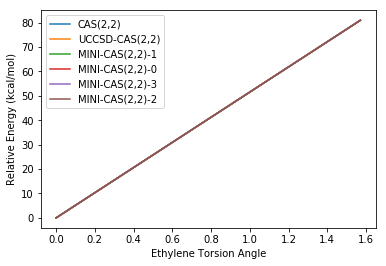

In [37]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
#pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
#pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
#pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
#pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
# for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:        
for key in ['CAS(2,2)']:
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in uccsd_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(uccsd_energies[key]) - uccsd_energies[key][0]),
               label="UCCSD-" + key)
for key in mini_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(mini_energies[key]) - mini_energies[key][0]),
               label="MINI-" + key)    
pylab.legend()
pylab.savefig("Ethylene_2_2_MINI_4Qubit.pdf")

C:\Users\hp\Documents\Github\CircuitNotebooks\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\hp\Documents\Github\CircuitNotebooks\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


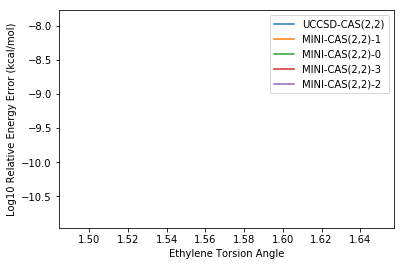

In [39]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Log10 Relative Energy Error (kcal/mol)")
for key in uccsd_energies:                       
    pylab.plot(angles, 
               np.log10(np.abs((np.array(uccsd_energies[key]) - uccsd_energies[key][0]) - 
                                  (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
               label="UCCSD-" + key)
for key in mini_energies:                       
    pylab.plot(angles, 
               np.log10(np.abs((np.array(mini_energies[key]) - mini_energies[key][0])- 
                                 (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
               label="MINI-" + key)
pylab.legend()
pylab.savefig("Ethylene_MINI_Err_4Qubit.pdf")